In [8]:
from pathlib import Path
import json
import pandas as pd
import pickle
from tqdm import tqdm

In [9]:
from dask import delayed
import dask.bag as db
from operator import add
from PIL import Image

In [10]:
from fastai.text import *
from fastai.callbacks import SaveModelCallback, ReduceLROnPlateauCallback, CSVLogger
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

In [11]:
from caption_generator_api.utils import *
from caption_generator_api.BeamSearch import *

In [12]:
gpu = torch.device('cuda:0')

In [15]:
CURRENT_PATH = Path('.')
LOCAL_PATH = Path('/home/data1/Project/work2')

In [20]:
%time generate_captions(drask_val_ann, drask_val_images, PATH/'val_data.pk')

CPU times: user 8 s, sys: 221 ms, total: 8.23 s
Wall time: 10.4 s


In [21]:
%time generate_captions(drask_train_ann, drask_train_images, PATH/'train_data.pk')

CPU times: user 17.4 s, sys: 474 ms, total: 17.9 s
Wall time: 22.4 s


In [16]:
valid_fns_caps = pickle.load(open(CURRENT_PATH/'all_valid_fns_caps.pkl', 'rb'))
train_fns_caps = pickle.load(open(CURRENT_PATH/'all_train_fns_caps.pkl', 'rb'))

In [9]:
!ls -altr {CURRENT_PATH}/'all_valid_fns_caps.pkl'
!ls -altr {CURRENT_PATH}/'all_train_fns_caps.pkl'

-rw-r--r-- 1 nobody nogroup 17556665 Jul 30 21:20 ./all_valid_fns_caps.pkl
-rw-r--r-- 1 nobody nogroup 38801145 Jul 30 21:20 ./all_train_fns_caps.pkl


## Tokenize

In [16]:
vocab = pickle.load((CURRENT_PATH/"vocab.pkl").open('rb'))

In [11]:
len(vocab.itos)

22400

In [29]:
def numericalize_tokens(tok):
    return np.array([vocab.numericalize(q) + [1] for q in tok])

def tqdm_helper(array, pct = 0.01) :
     return tqdm(total=len(array), file=sys.stdout, position=0, leave=True), len(array), int(len(array) * pct)
    
def build_data(fns_caps, PATH, name):
    filenames, captions = zip(*fns_caps)
    filenames = list(map(lambda x: str(PATH) +"/" + x,filenames))

    pbar, array_size, update_val = tqdm_helper(captions)

    captions_tok = list()
    for itr, c in enumerate(captions):
        captions_tok.append(numericalize_tokens(tokenizer.process_all(c)))
        if (itr % update_val == 0): pbar.update(update_val)
            
    dataset = (filenames, captions_tok)
    pickle.dump(dataset, open(str(PATH)+"/"+name+".pkl", 'wb'))

In [33]:
from dask.distributed import Client
client = Client(processes = True)

In [34]:
def build_data(fns_caps, PATH, name):
    caps_arr = (db.from_sequence(fns_caps)
     .map(lambda x : (x[0], [ numericalize_tokens(tokenizer._process_all_1([e]))[0] for e in x[1]])   )).compute()
    dataset = list(zip(*caps_arr))
    print("Write : ", str(PATH)+"/"+name+".pkl")
    pickle.dump(dataset, open(str(PATH)+"/"+name+".pkl", 'wb'))

In [37]:
#%time build_data(valid_fns_caps, PATH/'images'/'val2014', "valid")

Write :  /home/shajikk/WORK/MachineLearning/w251/Project/COCO/cocoapi/images/val2014/valid.pkl
CPU times: user 52.3 s, sys: 12.5 s, total: 1min 4s
Wall time: 37min 38s


In [17]:
valid_data = pickle.load(open(CURRENT_PATH/'all_valid_data.pkl', 'rb'))

In [39]:
#%time build_data(train_fns_caps, PATH/'images'/'train2014', "train")

Write :  /home/shajikk/WORK/MachineLearning/w251/Project/COCO/cocoapi/images/train2014/train.pkl
CPU times: user 1min 50s, sys: 24 s, total: 2min 14s
Wall time: 1h 18min 11s


In [18]:
#train_data = pickle.load(open(CURRENT_PATH/'all_train_data.pkl', 'rb'))

In [14]:
valid_fns_caps[-1], valid_fns_caps[1]

(('VizWiz_val_00007749.jpg',
  ['A  closeup of fiat with a value of 10 on a kitchen counter.',
   'a single piece of Australian currency sitting on a table.',
   'An Australian monetary bill with the value of 10 displayed.',
   'An Australian ten dollar bill sitting on a brown surface.',
   "A 10 dollar bill for Australia, has a woman's face on it."]),
 ('COCO_val2014_000000179765.jpg',
  ['A black Honda motorcycle parked in front of a garage.',
   'A Honda motorcycle parked in a grass driveway',
   'A black Honda motorcycle with a dark burgundy seat.',
   'Ma motorcycle parked on the gravel in front of a garage',
   'A motorcycle with its brake extended standing outside']))

In [19]:
def get_path(fn, path=CURRENT_PATH, tag='val') :
    if ("COCO_" in fn and tag == 'val') : fn = path/'COCO'/'cocoapi'/'images'/'val2014'/fn
    elif ("VizWiz_" in fn and tag == 'val') : fn = path/'vizwiz'/'data'/'val'/fn
    elif ("COCO_" in fn and tag == 'train') : fn = path/'COCO'/'cocoapi'/'images'/'train2014'/fn
    elif ("VizWiz_" in fn and tag == 'train') : fn = path/'vizwiz'/'data'/'train'/fn
    else : fn = 'error'
    return fn

In [20]:
def show_training_pair(path, tag, caption_dict, idx):
    fn, caption = caption_dict[idx]
    
    fn = get_path(fn, path, tag)
    print(fn)
    img = Image.open(fn)
    plt.imshow(img)
    print(caption)

vizwiz/data/val/VizWiz_val_00007749.jpg
['A  closeup of fiat with a value of 10 on a kitchen counter.', 'a single piece of Australian currency sitting on a table.', 'An Australian monetary bill with the value of 10 displayed.', 'An Australian ten dollar bill sitting on a brown surface.', "A 10 dollar bill for Australia, has a woman's face on it."]


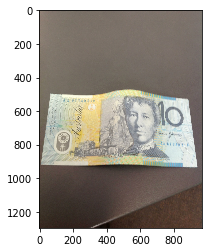

In [18]:
show_training_pair(CURRENT_PATH, 'val',valid_fns_caps, -1)

COCO/cocoapi/images/train2014/COCO_train2014_000000116100.jpg
['A panoramic view of a kitchen and all of its appliances.', 'A panoramic photo of a kitchen and dining room', 'A wide angle view of the kitchen work area', 'multiple photos of a brown and white kitchen. ', 'A kitchen that has a checkered patterned floor and white cabinets.']


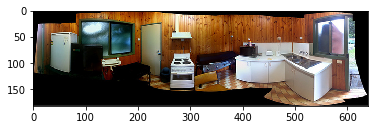

In [19]:
show_training_pair(CURRENT_PATH, 'train', train_fns_caps, 1)

## Tokenizer

In [18]:
tokenizer = Tokenizer(n_cpus=8)

In [45]:
train_captions_tokenized = tokenizer.process_all(
    list(itertools.chain.from_iterable(list(zip(*train_fns_caps))[1]))
)

In [17]:
vocab = Vocab.create(train_captions_tokenized, max_vocab=50000, min_freq=2)

In [18]:
#pickle.dump(vocab, open(CURRENT_PATH/"vocab.pkl", 'wb'))

In [21]:
vocab = pickle.load((CURRENT_PATH/"vocab.pkl").open('rb'))

In [22]:
len(vocab.itos)

22400

## Quick check

In [23]:
valid_data[0][0], valid_data[1][0]

('COCO_val2014_000000203564.jpg',
 [array([   9,  414, 4517,   15,    9,  101,  134,   13,   43, 1152,   10,    1]),
  array([   5,   13,  286,   48,    9,  101,  134,    9, 2054,   10,    1]),
  array([   9,   35,  315,  414,   15,    9,  101,  167,   13,   43, 1152,   10,    1]),
  array([   9,  414, 1988,   14,  446,   13,   43, 1152,   17, 8094,   15,    9,  101,  426,    1]),
  array([   9,  101,   15,   13, 7865,   11,   13, 1152,   11,    9,  414,    1])])

In [24]:
# valid_data[0] = list(map(lambda x: str((PATH/'images'/'val2014'/x).with_suffix('.jpkl')), valid_data[0]))
# train_data[0] = list(map(lambda x: str((PATH/'images'/'train2014'/x).with_suffix('.jpkl')), train_data[0]))
valid_data[0] = list(map(lambda x: str((get_path(x, LOCAL_PATH, 'val')).with_suffix('.jpkl')), valid_data[0]))
train_data[0] =  list(map(lambda x: str((get_path(x, LOCAL_PATH, 'train')).with_suffix('.jpkl')), train_data[0]))

In [26]:
valid_data[0][0], valid_data[1][0]

('/home/data1/Project/work2/COCO/cocoapi/images/val2014/COCO_val2014_000000203564.jpkl',
 [array([   9,  414, 4517,   15,    9,  101,  134,   13,   43, 1152,   10,    1]),
  array([   5,   13,  286,   48,    9,  101,  134,    9, 2054,   10,    1]),
  array([   9,   35,  315,  414,   15,    9,  101,  167,   13,   43, 1152,   10,    1]),
  array([   9,  414, 1988,   14,  446,   13,   43, 1152,   17, 8094,   15,    9,  101,  426,    1]),
  array([   9,  101,   15,   13, 7865,   11,   13, 1152,   11,    9,  414,    1])])

## Create dataset

In [27]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import ImageFile
import pdb
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [28]:
sz = 224


In [29]:
class ImageCaptionDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
          data (tuple): Contains a list of filenames and a list of tokenized and numericalized captions
          transforms (callable, optional): Optional transforms to be applied
        """
        self.filenames = data[0]
        self.captions  = data[1]
        self.transform = transform
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        # There are grayscale images in dataset and tensor shapes have to match except in dim=0
        #image = Image.open(self.filenames[idx]).convert('RGB')
        image = pickle.load(open(self.filenames[idx], 'rb'))
        caption = self.captions[idx][random.randint(0, len(self.captions[idx]) - 1)]
        
        if self.transform is not None:
            image = self.transform(image)
        
        return (image, caption)

In [30]:
def pad_collate_ImgCap(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False, transpose:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    images, captions = zip(*samples)
    max_len_cap = max([len(c) for c in captions])
    
    res_cap = torch.zeros(len(samples), max_len_cap).long() + pad_idx
    
    if backwards: pad_first = not pad_first
    for i,c in enumerate(captions):
        if pad_first: 
            res_cap[i,-len(c):] = LongTensor(c)
        else:         
            res_cap[i,:len(c)] = LongTensor(c)
    
    if backwards:
        cap = cap.flip(1)
    if transpose:
        res_cap.transpose_(0,1)
    
    return (torch.stack(images, 0, out=None), res_cap), res_cap

In [31]:
tfms = transforms.Compose([
    transforms.Resize(sz),
    #transforms.RandomRotation(10, expand=False),
    transforms.CenterCrop(sz),
    #transforms.RandomCrop(224),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5238, 0.5003, 0.4718],[0.3159, 0.3091, 0.3216])
])


valid_tfms = transforms.Compose([
    transforms.Resize(sz),
    transforms.CenterCrop(sz),
    transforms.ToTensor(),
    transforms.Normalize([0.5238, 0.5003, 0.4718], [0.3159, 0.3091, 0.3216])
])


In [32]:
inv_normalize = transforms.Normalize(
    mean=[-0.5238/0.3159, -0.5003/0.3091, -0.4718/0.3216],
    std=[1/0.3159, 1/0.3091, 1/0.3216]
)
denorm = transforms.Compose([
    inv_normalize,
    transforms.functional.to_pil_image
])

## Check & set dataset

In [33]:
valid_dataset = ImageCaptionDataset(valid_data, transform=tfms)
train_dataset = ImageCaptionDataset(train_data, transform=tfms)

In [34]:
print(
    "Valid dataset: {}\nTrain dataset: {}\n".format(len(valid_dataset), len(train_dataset))
)

Valid dataset: 48046
Train dataset: 105649



xxmaj woman standing in a parking lot with a pink bicycle xxpad


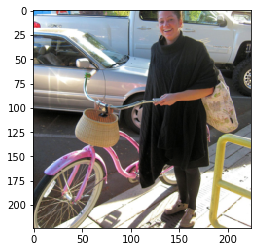

In [35]:
idx = 1085
d = train_dataset
img, cap = d[idx]
print(vocab.textify(cap))
plt.imshow(denorm(img))

In [36]:
def pad_collate_ImgCap(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False, transpose:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    images, captions = zip(*samples)
    max_len_cap = max([len(c) for c in captions])
    
    res_cap = torch.zeros(len(samples), max_len_cap).long() + pad_idx
    
    if backwards: pad_first = not pad_first
    for i,c in enumerate(captions):
        if pad_first: 
            res_cap[i,-len(c):] = LongTensor(c)
        else:         
            res_cap[i,:len(c)] = LongTensor(c)
    
    if backwards:
        cap = cap.flip(1)
    if transpose:
        res_cap.transpose_(0,1)
    
    return (torch.stack(images, 0, out=None), res_cap), res_cap

imgcap_collate_func = partial(pad_collate_ImgCap, pad_first=False, transpose=True)

## Build data loaders

In [37]:
bs = 224

In [38]:
val_sampler = SortSampler(valid_data[1], key=lambda x:len(valid_data[1][x]))
trn_sampler = SortishSampler(train_data[1], key=lambda x: len(train_data[1][x]), bs=bs)

In [39]:
val_dl = DataLoader(dataset=valid_dataset, batch_size=bs, sampler=val_sampler, collate_fn=imgcap_collate_func, num_workers=16)
trn_dl = DataLoader(dataset=train_dataset, batch_size=bs, sampler=trn_sampler, collate_fn=imgcap_collate_func, num_workers=16)

In [32]:
seq_PATH = CURRENT_PATH/'seq2deq_model'
seq_PATH.mkdir(exist_ok=True)

In [78]:
import fasttext as ft
#en_vecs = ft.load_model(str(PATH)+'/../fastText/cc.en.300.bin')

In [79]:
#vec_dict = {w : en_vecs.get_word_vector(w) for w in en_vecs.get_words()}

In [80]:
#pickle.dump(vec_dict, open(seq_PATH/'vec_dict.pkl', 'wb'))

In [40]:
vec_dict = pickle.load(open(CURRENT_PATH/'vec_dict.pkl','rb'))

In [41]:
def create_emb(wordvecs, itos, emb_sz):
    emb= nn.Embedding(len(itos), emb_sz, padding_idx=1)
    weights = emb.weight.data
    not_found = []
    
    for idx, word in enumerate(itos):
        try:
            weights[idx] = torch.from_numpy(wordvecs[word] * 3)
        except:
            not_found.append(word)
    print(len(not_found), not_found[5:10])
    return emb

## Model

In [42]:
from torchvision import models

In [43]:
n_hid, n_layers = 400, 3
emb_sz = 300

In [44]:
def MLP(n_in, n_out, p=0.2):
    return nn.Sequential(
        Flatten(),
        #nn.BatchNorm1d(n_in),
        #nn.Dropout(p),
        nn.Linear(in_features=n_in, out_features=n_in, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=n_in, out_features=n_in, bias=True),
        nn.ReLU(),
        #nn.Linear(in_features=2048, out_features=2048, bias=True),
        #nn.ReLU(),
        #nn.BatchNorm1d(n_in),
        #nn.Dropout(p),
        nn.Linear(in_features=n_in, out_features=n_out, bias=True)
    )

In [45]:
class Encoder(nn.Module):
    def __init__(self, device, dec_hidden_state_size, dec_layers, filter_width, num_filters):
        super().__init__()
        # Visual Encoder
        self.device = device
        self.base_network = nn.Sequential(*list(models.resnet34(pretrained=True).children())[:-2])
        self.freeze_base_network()
        self.concatPool = AdaptiveConcatPool2d(sz=1)
        self.adaptivePool = nn.AdaptiveAvgPool2d((filter_width, filter_width))
        self.filter_width = filter_width
        
        self.output_layers = nn.ModuleList([
            MLP(2*num_filters, dec_hidden_state_size) for _ in range(dec_layers)
        ])
        
        
    def forward(self, inp):
        #pdb.set_trace()
        enc_output = self.base_network(inp)
        annotation_vecs = self.adaptivePool(enc_output).view(enc_output.size(0), enc_output.size(1), -1)
        enc_output = self.concatPool(enc_output)
        
        dec_init_hidden_states = [MLP_layer(enc_output) for MLP_layer in self.output_layers]
        
        return torch.stack(dec_init_hidden_states, dim = 0), annotation_vecs.transpose(1, 2)
    
    def freeze_base_network(self):
        for layer in self.base_network:
            requires_grad(layer, False)
            
    def fine_tune(self, from_block=-1):
        for layer in self.base_network[from_block:]:
            requires_grad(layer, True)

In [46]:
class VisualAttention(nn.Module):
    def __init__(self, num_filters, dec_dim, att_dim):
        super().__init__()
        self.attend_annot_vec = nn.Linear(num_filters, att_dim)
        self.attend_dec_hidden= nn.Linear(dec_dim, att_dim)
        self.f_att = nn.Linear(att_dim, 1)  # Equation (4) in Xu et al. (2015)
        
    def forward(self, annotation_vecs, dec_hid_state):
        #pdb.set_trace()
        attended_annotation_vecs = self.attend_annot_vec(annotation_vecs)
        attended_dec_hid_state   = self.attend_dec_hidden(dec_hid_state)
        e = self.f_att(F.relu(attended_annotation_vecs + attended_dec_hid_state.unsqueeze(1))).squeeze(2)  # Eq. 4
        alphas = F.softmax(e, dim=1)  # Equation (5) in Xu et al. (2015)
        context_vec = (annotation_vecs * alphas.unsqueeze(2)).sum(1)  # Equations (13)
        
        return context_vec, alphas

In [47]:
from random import choice

class ImageCaptionGenerator(nn.Module):
    def __init__(self, device, filter_width, num_filters, vocab_size, emb_sz, out_seqlen, n_layers=3, prob_teach_forcing=1, p_drop=0.3):
        super().__init__()
        self.n_layers, self.out_seqlen = n_layers, out_seqlen
        self.filter_width = filter_width
        self.num_filters = num_filters
        self.device = device  
        
        # Encoder
        self.encoder = Encoder(device, emb_sz, n_layers, filter_width, num_filters)
        
        # Attention
        self.att = VisualAttention(num_filters, emb_sz, 500)
        
        # Decoder
        self.emb = nn.Embedding(vocab_size, emb_sz) #create_emb(wordvecs, itos, emb_sz)
        self.rnn_dec = nn.GRU(num_filters + emb_sz, emb_sz, num_layers=n_layers, dropout=0 if n_layers == 1 else p_drop)  # square to enable weight tying
        self.out_drop = nn.Dropout(p_drop)
        self.out = nn.Linear(emb_sz, vocab_size)
        self.out.weight.data = self.emb.weight.data
        self.f_b = nn.Linear(emb_sz, num_filters)  # Section 4.2.1 in Xu et al. (2015)
        
        self.prob_teach_forcing = prob_teach_forcing
        self.initializer()
        
    def initializer(self):
        self.emb.weight.data.uniform_(-0.1, 0.1)
        
    def select_val(self, t) :
        max_col = t.argsort(descending=True, dim=1).shape[1]
        if max_col > 2 : max_col = 2
        else : max_col = max_col - 1
        selected_col = random.randint(0, max_col)
        return t.argsort(descending=True, dim=1)[:,selected_col]
    
        
    def forward(self, x, y=None):
        #pdb.set_trace()
        h, annotation_vecs = self.encode(x)

        dec_inp = torch.zeros(h.size(1), requires_grad=False).long()
        dec_inp = dec_inp.to(self.device)
        res = []
        alphas = []
        
        for i in range(self.out_seqlen):
            #pdb.set_trace()
            dec_output, h, alpha = self.decode_step(dec_inp, h, annotation_vecs)
            res.append(dec_output)
            alphas.append(alpha)
            
            if (dec_inp == 1).all() or (y is not None and i >= len(y)):
                break            
            # teacher forcing
            elif y is not None and (self.prob_teach_forcing > 0) and (random.random() < self.prob_teach_forcing):
                dec_inp = y[i].to(self.device)
            else:
                dec_inp = dec_output.data.max(1)[1]  # [1] to get argmax
                #dec_inp = self.select_val(dec_output)

        return torch.stack(res), torch.stack(alphas)
    
    def encode(self, x):
        return self.encoder(x.to(self.device))
    
    def decode_step(self, dec_inp, h, annotation_vecs):
        #pdb.set_trace()
        context_vec, alpha = self.att(annotation_vecs, h[-1])
        beta = torch.sigmoid(self.f_b(h[-1]))
        context_vec = beta * context_vec  # Section 4.2.1 in Xu et al. (2015)
        
        emb_inp = self.emb(dec_inp).unsqueeze(0)  # adds unit axis at beginning so that rnn 'loops' once

        output, h = self.rnn_dec(torch.cat([emb_inp, context_vec.unsqueeze(0)], dim=2), h)
        output = self.out(self.out_drop(output[0]))

        return F.log_softmax(output, dim=1), h, alpha

In [48]:
@dataclass
class TeacherForcingCallback(Callback):
    def __init__(self, learn:Learner):
        super().__init__()
        self.learn = learn
    
    def on_epoch_begin(self, epoch: int, **kwargs: Any) -> None:
        self.learn.model.prob_teach_forcing = (30-epoch) * 1/30 if epoch < 30 else 0

In [49]:
def ImageCaptionLoss(pred, target, lamb = 1):
    pred, alphas = pred
    seqlen, bs = target.size()
    seqlen_pred, bs_pred, n_probs = pred.size()
    
    # we need to pad if target seqlen is larger than prediction seqlen
    if seqlen > seqlen_pred:
        pred = F.pad(pred, (0,0,0,0,0,seqlen-seqlen_pred))
    
    # but we only compare until the seqlen of the target
    pred = pred[:seqlen]
    
    # cross_entropy can't handle rank 3 tensors currently, we need to flatten
    loss = F.nll_loss(pred.contiguous().view(-1, n_probs), target.contiguous().view(-1))
    
    # See section 4.2.1 "Doubly stocastic attention"
    penalty = ((1. - alphas.sum(0)) ** 2.).mean()
    # ((1. - alphas.sum(0)) ** 2.).sum(1).mean()

    return loss + lamb * penalty

## Metrics - BLEU score

In [50]:
from nltk.translate.bleu_score import corpus_bleu

class BleuMetric(Callback):
    def on_epoch_begin(self, **kwargs):
        self.references = list()
        self.candidates = list()
        
    def on_batch_end(self, last_output, last_target, **kwargs):
        #pdb.set_trace()
        num_sentences = last_output[0].size(1)
        cands = last_output[0].data.max(2)[1].transpose(1,0).chunk(num_sentences, 0)
        refs = last_target.transpose(1,0).chunk(num_sentences, 0)
        
        self.candidates.extend([[tok for tok in c[0].cpu().numpy() if tok != 1] for c in cands])
        self.references.extend([[[tok for tok in r[0].cpu().numpy() if tok != 1]] for r in refs])
        
    def on_epoch_end(self, last_metrics, **kwargs):
        #pdb.set_trace()
        assert len(self.references) == len(self.candidates)
        return add_metrics(last_metrics, corpus_bleu(self.references, self.candidates))

In [51]:
imgCapGen = ImageCaptionGenerator(gpu, 7, 512, len(vocab.itos), emb_sz, 50, n_layers, p_drop=0.2)

In [52]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [53]:
dataBunch = DataBunch(train_dl=trn_dl, valid_dl=val_dl, device=gpu, path=CURRENT_PATH, collate_fn=imgcap_collate_func)

In [54]:
learn = Learner(data=dataBunch, model=to_device(imgCapGen, gpu), opt_func=opt_fn, loss_func=ImageCaptionLoss, callback_fns=[ShowGraph], metrics=[BleuMetric()]) # , BnFreeze 


In [68]:
learn.lr_find()

epoch,train_loss,valid_loss,bleu_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


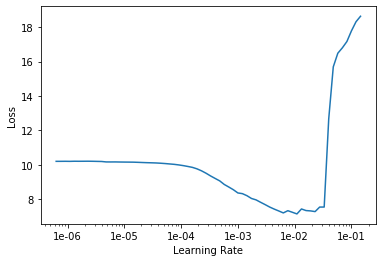

In [69]:
learn.recorder.plot(skip_end=5)

In [70]:
lr = 1e-3

epoch,train_loss,valid_loss,bleu_metric,time
0,2.332379,2.391975,0.000000,09:02
1,2.181411,2.137060,0.005739,09:57
2,1.931802,1.911372,0.023138,10:18
3,1.773514,1.789266,0.037466,10:44
4,1.583558,1.611263,0.049151,10:00
5,1.425659,1.571489,0.060136,09:29
6,1.432159,1.456838,0.075335,09:20
7,1.346035,1.385124,0.083351,09:27
8,1.327425,1.389884,0.090985,09:20
9,1.351277,1.326139,0.096528,09:48


/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


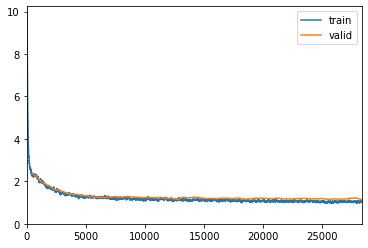

Better model found at epoch 0 with bleu_metric value: 2.2319671861337208e-79.
Better model found at epoch 1 with bleu_metric value: 0.005739263487693482.
Better model found at epoch 2 with bleu_metric value: 0.023137852392665574.
Better model found at epoch 3 with bleu_metric value: 0.03746598868744686.
Better model found at epoch 4 with bleu_metric value: 0.049150699634386265.
Better model found at epoch 5 with bleu_metric value: 0.060136222735721966.
Better model found at epoch 6 with bleu_metric value: 0.07533527443673124.
Better model found at epoch 7 with bleu_metric value: 0.08335070233453387.
Better model found at epoch 8 with bleu_metric value: 0.09098507017360463.
Better model found at epoch 9 with bleu_metric value: 0.09652824300895183.
Better model found at epoch 10 with bleu_metric value: 0.09950080793731815.
Better model found at epoch 11 with bleu_metric value: 0.10202966144744766.
Better model found at epoch 12 with bleu_metric value: 0.10576651512798182.
Better model fo

In [71]:
learn.fit_one_cycle(60, lr, callbacks=[
    SaveModelCallback(learn, monitor='bleu_metric'),
    CSVLogger(learn, filename='train_img_cap_gen')
                                     ])

In [72]:
learn.save("model_conceptual_captions_stage1")

In [52]:
learn.load("bestmodel");

In [75]:
learn.lr_find()

epoch,train_loss,valid_loss,bleu_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


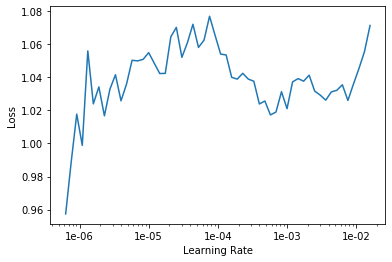

In [77]:
learn.recorder.plot(skip_end=5)

In [53]:
lr = 1e-04

epoch,train_loss,valid_loss,bleu_metric,time
0,1.056648,1.188538,0.131649,09:40
1,1.035534,1.175032,0.130841,09:59
2,1.007958,1.193004,0.130269,10:00
3,1.044883,1.146018,0.130786,10:02
4,1.029515,1.202186,0.131218,09:39
5,1.031087,1.176207,0.130529,09:52
6,1.003250,1.160500,0.129903,09:18
7,1.032861,1.159714,0.130436,09:24
8,1.015318,1.205824,0.130623,09:22
9,1.057456,1.191984,0.131419,09:08


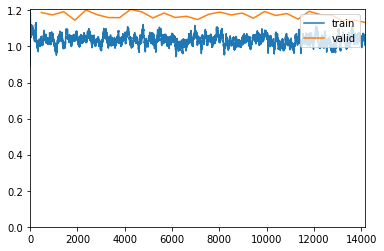

Better model found at epoch 0 with bleu_metric value: 0.13164860193452368.
Better model found at epoch 17 with bleu_metric value: 0.13204397928273168.


In [54]:
learn.fit_one_cycle(30, lr, callbacks=[
    SaveModelCallback(learn, monitor='bleu_metric'),
    CSVLogger(learn, filename='train_img_cap_gen')
                                     ])

In [57]:
learn.load("bestmodel");
learn.save("model_conceptual_captions_stage2")

In [58]:
learn.lr_find()

epoch,train_loss,valid_loss,bleu_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


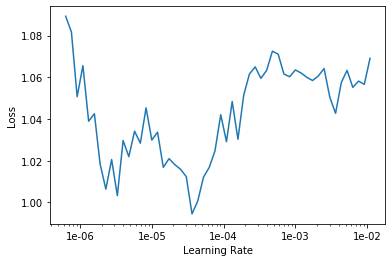

In [59]:
learn.recorder.plot(skip_end=5)

In [60]:
lr = 1e-06

epoch,train_loss,valid_loss,bleu_metric,time
0,1.059377,1.165686,0.131428,09:02
1,1.016732,1.167232,0.130158,09:50
2,1.053635,1.166316,0.131201,09:55
3,1.051505,1.177661,0.131157,09:27
4,0.995420,1.158011,0.130852,09:17
5,1.046300,1.174578,0.131970,09:25
6,1.014585,1.170931,0.130708,09:19
7,1.051136,1.200614,0.131101,09:21
8,1.065088,1.187769,0.130551,09:38
9,1.062594,1.148043,0.130420,09:32


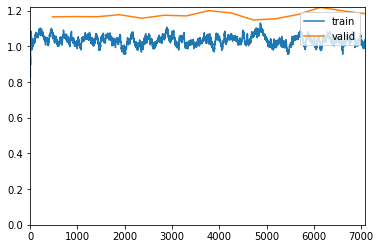

Better model found at epoch 0 with bleu_metric value: 0.13142767773593.
Better model found at epoch 5 with bleu_metric value: 0.13196976264669116.
Better model found at epoch 12 with bleu_metric value: 0.13217287481694776.


In [61]:
learn.fit_one_cycle(15, lr, callbacks=[
    SaveModelCallback(learn, monitor='bleu_metric'),
    CSVLogger(learn, filename='train_img_cap_gen')
                                     ])

In [62]:
learn.load("bestmodel");
learn.save("model_conceptual_captions_stage3")

In [63]:
learn.lr_find()

epoch,train_loss,valid_loss,bleu_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


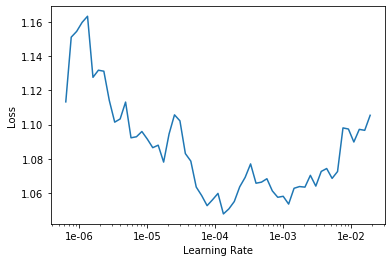

In [65]:
learn.recorder.plot(skip_end=5)

In [66]:
lr = 1e-06

epoch,train_loss,valid_loss,bleu_metric,time
0,1.011177,1.167369,0.130488,09:51
1,1.061411,1.120909,0.129880,09:58
2,1.017988,1.187867,0.130655,09:51
3,1.037336,1.170623,0.130654,09:29
4,1.011451,1.142250,0.131001,09:40
5,1.051186,1.181760,0.130611,09:40
6,0.991386,1.185369,0.132007,09:47
7,1.051678,1.165649,0.131214,09:53
8,1.021514,1.165011,0.131352,09:36
9,1.043358,1.175800,0.130680,09:45


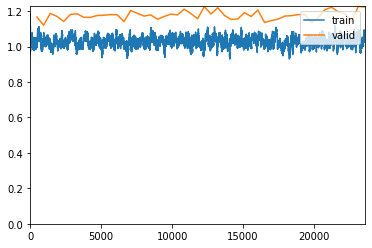

Better model found at epoch 0 with bleu_metric value: 0.1304883434655261.
Better model found at epoch 2 with bleu_metric value: 0.1306545622848386.
Better model found at epoch 4 with bleu_metric value: 0.13100119293557785.
Better model found at epoch 6 with bleu_metric value: 0.13200717375805157.


In [67]:
learn.fit_one_cycle(50, lr, callbacks=[
    SaveModelCallback(learn, monitor='bleu_metric'),
    CSVLogger(learn, filename='train_img_cap_gen')
                                     ])

In [68]:
learn.load("bestmodel");
learn.save("model_conceptual_captions_stage4")

In [55]:
learn.load("model_conceptual_captions_stage4");
learn.model.encoder.fine_tune(-1)
lr = 1e-08

epoch,train_loss,valid_loss,bleu_metric,time
0,1.004616,1.159275,0.131249,08:38
1,1.024471,1.174946,0.131412,08:57
2,1.010459,1.194507,0.129515,08:44
3,1.000574,1.206410,0.130229,08:54
4,1.093023,1.198592,0.130362,08:56
5,1.029998,1.154040,0.130493,08:52
6,0.997677,1.151793,0.130539,08:43
7,1.068120,1.181187,0.129780,08:42
8,0.999795,1.201042,0.131097,08:48
9,1.037154,1.158022,0.130084,08:57


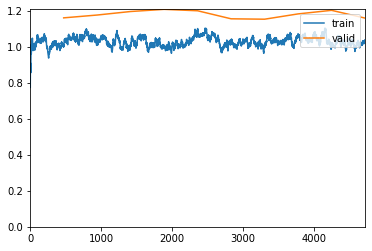

Better model found at epoch 0 with bleu_metric value: 0.13124915076299415.
Better model found at epoch 1 with bleu_metric value: 0.13141212133356284.


In [56]:
learn.fit_one_cycle(10, lr, callbacks=[
    SaveModelCallback(learn, monitor='bleu_metric'),
    CSVLogger(learn, filename='train_img_cap_gen')
                                     ])

In [57]:
%%capture
for l in list(learn.model.encoder.children())[0]:
    print(l, requires_grad(l))

In [58]:
learn.model.eval();

In [59]:
beam_width = 5

In [60]:
beam_search = BeamSearch(learn.model.encode, learn.model.decode_step, beam_width)

In [61]:
learn.save("model_resnet34_v100_coco_vizwiz")

## Predictions

### Regular

In [126]:
def get_captions(image):
    img = Image.open(image)
    im = valid_tfms(img)
    results = beam_search(im)
    txt = vocab.textify(results[0])
    txt = txt.replace(" xxmaj", "")
    txt = txt.replace("xxmaj", "")
    return(txt)
    
def predict_value(image):
    img = Image.open(image)
    im = valid_tfms(img)
    txt = get_captions(image)
    print(txt)
    plt.imshow(denorm(im))

a living room with a couch and a table


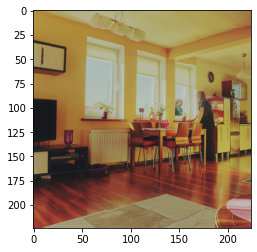

In [127]:
predict_value('COCO/cocoapi/images/val2014/COCO_val2014_000000000139.jpg')

a bathroom with a toilet , sink and shower .


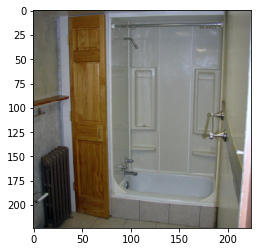

In [128]:
predict_value('COCO/cocoapi/images/val2014/COCO_val2014_000000581863.jpg')

a glass of wine sitting on a table next to a wine glass .


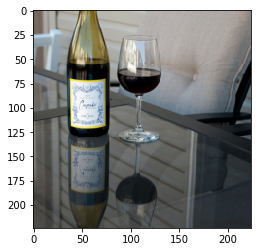

In [129]:
predict_value('COCO/cocoapi/images/val2014/COCO_val2014_000000000283.jpg')

a dog that is sitting on a bench .


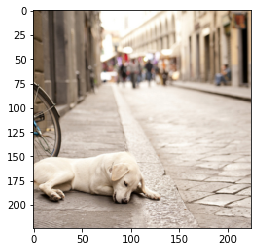

In [130]:
predict_value('COCO/cocoapi/images/val2014/COCO_val2014_000000000074.jpg')

a wooden dresser with a wooden dresser and a wooden dresser .


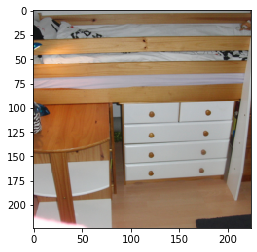

In [131]:
predict_value('COCO/cocoapi/images/val2014/COCO_val2014_000000000133.jpg')

a baseball player holding a bat on top of a field .


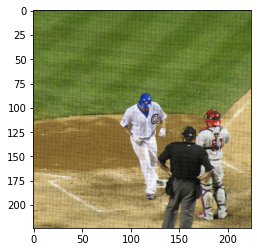

In [132]:
predict_value('COCO/cocoapi/images/val2014/COCO_val2014_000000000192.jpg')

a wooden bench in the middle of a forest .


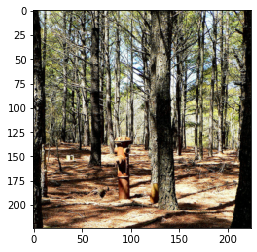

In [133]:
predict_value('COCO/cocoapi/images/val2014/COCO_val2014_000000581731.jpg')

a train is pulling into a train station .


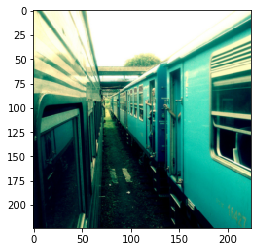

In [134]:
predict_value('COCO/cocoapi/images/val2014/COCO_val2014_000000581899.jpg')

## Vizwiz

a black iphone with a black screen on top of a white surface .


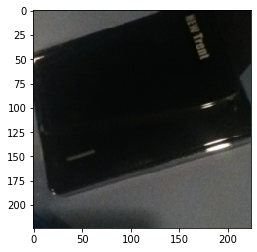

In [135]:
predict_value('vizwiz/data/test/VizWiz_test_00000000.jpg')

 the top of a black object with a dark background .


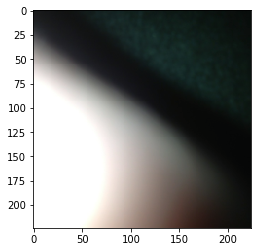

In [136]:
predict_value('vizwiz/data/test/VizWiz_test_00000001.jpg')

 an electronic device with a digital display on it .


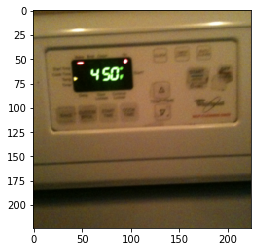

In [137]:
predict_value('vizwiz/data/test/VizWiz_test_00000002.jpg')

 an open laptop computer with a screen on the screen .


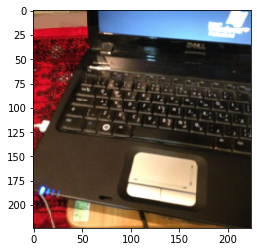

In [138]:
predict_value('vizwiz/data/test/VizWiz_test_00000003.jpg')

a can of coca - cola is on top of a counter .


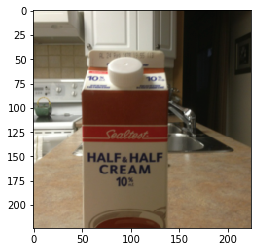

In [139]:
predict_value('vizwiz/data/test/VizWiz_test_00000004.jpg')

 the top of a computer screen showing a captcha on the screen .


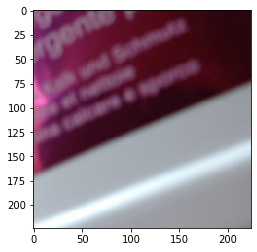

In [140]:
predict_value('vizwiz/data/test/VizWiz_test_00000005.jpg')

a person is holding a pair of scissors in their hand .


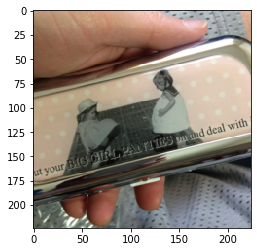

In [141]:
predict_value('vizwiz/data/test/VizWiz_test_00000006.jpg')

a green apple sitting on top of a wooden table .


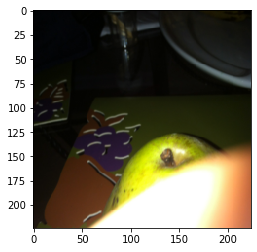

In [142]:
predict_value('vizwiz/data/test/VizWiz_test_00000007.jpg')

a person is holding a can of coca - cola .


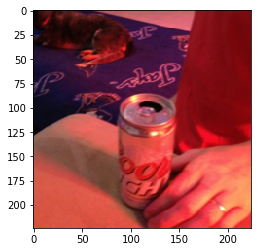

In [143]:
predict_value('vizwiz/data/test/VizWiz_test_00000008.jpg')

a white plate topped with a sandwich and fries .


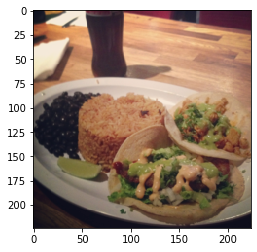

In [144]:
predict_value('vizwiz/data/test/VizWiz_test_00000009.jpg')

## Generate result (For Vizwiz competition)

In [147]:
from tqdm import tqdm

In [148]:
vizwiz_result = []
vizwiz_result_all = []
vizwiz_test_dict = pickle.load(open(CURRENT_PATH/'vizwiz_test_dict.pkl', 'rb'))
for v in tqdm(vizwiz_test_dict) :
    file = v['file_name']
    caption = 'test'
    caption = get_captions(file)
    vizwiz_result.append({ 'image_id' : v['image_id'], 'caption' : caption})
    vizwiz_result_all.append({ 'image_id' : v['image_id'], 'caption' : caption, 'file_name' : v['file_name']})
    
json_object = json.dumps(vizwiz_result, indent = 4)   
with open('vizwiz_result.json', 'w') as fp: fp.write(json_object)

100%|██████████| 8000/8000 [24:38<00:00,  5.41it/s]


In [149]:
!ls vizwiz_result.json

vizwiz_result.json


In [151]:
!cat vizwiz_result.json | grep caption | tail -14

        "caption": "a computer screen is displaying a message on a computer screen ."
        "caption": "a computer screen with a captcha code on it"
        "caption": "a computer screen with a message on it ."
        "caption": "a piece of paper with a math problem on it ."
        "caption": "a package of food is on top of a counter ."
        "caption": "a person is holding a can of food in their hand ."
        "caption": " the back of a box of healthy choice brand french roast coffee ."
        "caption": "a computer screen with a picture of a website on it ."
        "caption": "a man sitting in front of a xxup tv in a living room ."
        "caption": "a computer screen with a message on the screen ."
        "caption": "a white bottle with a white label and a white label ."
        "caption": "a laptop computer sitting on top of a desk ."
        "caption": "a person is holding a white card with a barcode on it ."
        "caption": "a screenshot of a computer screen with a 